# Predição de Preços de Imóveis – Caixa Econômica Federal


## Introdução

Este notebook desenvolve e avalia modelos de predição de preços de imóveis a partir de dados de leilões da Caixa Econômica Federal. O objetivo é comparar abordagens lineares e não lineares e analisar o papel de características físicas, locacionais e institucionais na explicação dos preços observados.

Dada a presença de não linearidades, alta cardinalidade categórica e heterogeneidade espacial, optou-se por modelos baseados em árvores, com destaque para o CatBoost. A análise distingue explicitamente entre modelos de natureza estrutural, voltados à interpretação econômica, e modelos estritamente preditivos, cujo foco é a maximização da acurácia.

Ao longo do notebook, são apresentados os dados, a construção dos cenários de modelagem, os resultados empíricos e sua interpretação.

## Contexto institucional dos dados

Os dados utilizados referem-se a imóveis alienados pela Caixa Econômica Federal por meio de leilões e vendas online. Esses imóveis são, em sua maioria, ativos retomados pelo banco, frequentemente em decorrência de inadimplência, e disponibilizados ao público por meio de editais oficiais.

As vendas ocorrem em diferentes modalidades previstas em lei, com regras específicas de formação de preço. Observa-se empiricamente que as modalidades iniciais apresentam baixa taxa de arremate. Por esse motivo, a análise concentra-se nas modalidades de Licitação Aberta e Venda Online, nas quais efetivamente se observa a maior parte das transações.

## Preparação e estrutura dos dados

Esta seção descreve a origem dos dados, a unidade de observação e os critérios adotados para seleção e organização das variáveis utilizadas nos modelos.


### Dicionário de variáveis

A tabela a seguir apresenta as principais variáveis utilizadas na análise, agrupadas de acordo com sua natureza econômica e institucional. Foram consideradas exclusivamente informações disponíveis nos anúncios dos editais, isto é, anteriores ao processo de arrematação.

In [25]:
import pandas as pd
import numpy as np

path = r"G:\My Drive\Github\py-2025-epge-dados1-finalassignment\data\input\resultados_merged.parquet"

df = pd.read_parquet(path)
df.shape

(27928, 56)

In [26]:
df_dicionario = pd.DataFrame([
    {"grupo": "Target", "variavel": "log_valor_oferta", "descricao": "Log do valor final ofertado no imóvel"},

    {"grupo": "Locacional", "variavel": "uf", "descricao": "Estado do imóvel (Exemplo: SP, RJ)"},
    {"grupo": "Locacional", "variavel": "cidade", "descricao": "Município do imóvel (Exemplo: São Paulo, Rio de Janeiro)"},
    {"grupo": "Locacional", "variavel": "bairro", "descricao": "Bairro do imóvel (Exemplo: Centro, Copacabana)"},

    {"grupo": "Imóvel", "variavel": "area_privativa", "descricao": "Área privativa (m²)"},
    {"grupo": "Imóvel", "variavel": "area_terreno", "descricao": "Área do terreno (m²)"},
    {"grupo": "Imóvel", "variavel": "tipo_imovel", "descricao": "Tipo do imóvel"},

    {"grupo": "Leilão", "variavel": "modalidade_venda", "descricao": "Modalidade de venda do edital (Exemplo: Licitação Aberta, Venda Direta)"},

    {"grupo": "Financeiro", "variavel": "preco", "descricao": "Preço inicial  definido no edital de acordo com a modalidade de venda e requisitos previstos em lei"},
    {"grupo": "Financeiro", "variavel": "valor_avaliacao", "descricao": "Valor de avaliação da Caixa"}
])

In [27]:
# Passo 1 — Definir o target (y)

y = np.log(df["valor_oferta"])

# Converter data_licitacao para datetime (tenta ISO e depois dia/mês/ano)
d = pd.to_datetime(df["data_licitacao"], errors="coerce")
if d.isna().mean() > 0.5:
    d = pd.to_datetime(df["data_licitacao"], errors="coerce", dayfirst=True)

df["data_licitacao_dt"] = d
df["ano"] = df["data_licitacao_dt"].dt.year
df["mes"] = df["data_licitacao_dt"].dt.month

cutoff_test = df["data_licitacao_dt"].max() - pd.DateOffset(months=6)
is_test = df["data_licitacao_dt"] >= cutoff_test


# Criar variáveis derivadas mínimas

df["bairro_std"] = df["bairro"].astype(str).str.upper().str.strip()
df.loc[df["bairro"].isna(), "bairro_std"] = "MISSING"

df["cidade_std"] = df["cidade.x"].astype(str).str.upper().str.strip()
df.loc[df["cidade.x"].isna(), "cidade_std"] = "MISSING"

df["uf_cidade"] = df["uf.x"].astype(str) + "_" + df["cidade_std"].astype(str)
df["uf_cidade_bairro"] = df["uf_cidade"] + "_" + df["bairro_std"]


# calcula frequências APENAS no treino
counts_train = df.loc[~is_test, "uf_cidade_bairro"].value_counts()
valid_train = counts_train[counts_train >= 15].index

# aplica a regra ao dataset inteiro (ok)
df["uf_cidade_bairro_f"] = np.where(
    df["uf_cidade_bairro"].isin(valid_train),
    df["uf_cidade_bairro"],
    "OUTROS_BAIRROS"
)

count_cols = [ "area_total", "area_privativa", "area_terreno", "quartos", "salas", "vagas_garagem", 
              "lavabos", "suites", "cozinhas", "varandas", "sacadas", "terracos", "areas_servico", 
              "dce", "churrasqueiras", "wc", "wc_emp"
]

for c in count_cols:
    df[f"{c}_missing"] = df[c].isna().astype(int)

In [28]:
summary_ano = (
    df.groupby(["ano", "tipo", "modalidade_de_venda.x"])
      .agg(
          qtd_imoveis=("valor_oferta", "count"),
          valor_total_em_milhoes_RS=("valor_oferta", "sum"),
          valor_medio_em_milhoes_RS=("valor_oferta", "mean"),
          valor_mediano_em_milhoes_RS=("valor_oferta", "median")
      )
      .reset_index()
      .sort_values(["ano", "valor_total_em_milhoes_RS"], ascending=[True, False])
)

# Converter para milhões (numérico)
summary_ano["valor_total_em_milhoes_RS"]   = summary_ano["valor_total_em_milhoes_RS"]  / 1_000_000
summary_ano["valor_medio_em_milhoes_RS"]   = summary_ano["valor_medio_em_milhoes_RS"]   / 1_000_000
summary_ano["valor_mediano_em_milhoes_RS"] = summary_ano["valor_mediano_em_milhoes_RS"] / 1_000_000

summary_ano[["valor_total_em_milhoes_RS", "valor_medio_em_milhoes_RS", "valor_mediano_em_milhoes_RS"]] = \
    summary_ano[["valor_total_em_milhoes_RS", "valor_medio_em_milhoes_RS", "valor_mediano_em_milhoes_RS"]].round(1)

summary_ano

,ano,tipo,modalidade_de_venda.x,qtd_imoveis,valor_total_em_milhoes_RS,valor_medio_em_milhoes_RS,valor_mediano_em_milhoes_RS
2,2023,Casa,venda_online,51,6.1,0.1,0.1
0,2023,Apartamento,venda_online,17,1.6,0.1,0.1
5,2023,Terreno,venda_online,9,1.4,0.2,0.1
3,2023,Imóvel rural,venda_online,3,1.0,0.3,0.3
4,2023,Loja,venda_online,3,0.5,0.2,0.1
1,2023,Casa,licitacao_aberta,1,0.1,0.1,0.1
6,2024,Apartamento,licitacao_aberta,3442,442.0,0.1,0.1
7,2024,Apartamento,venda_online,2084,263.6,0.1,0.1
9,2024,Casa,venda_online,1749,254.4,0.1,0.1
8,2024,Casa,licitacao_aberta,1490,191.5,0.1,0.1


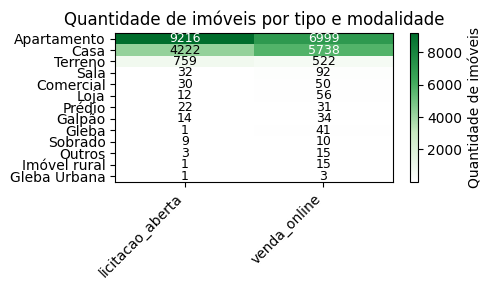

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# matriz tipo x modalidade
matriz = (
    summary_ano
      .pivot_table(
          index="tipo",
          columns="modalidade_de_venda.x",
          values="qtd_imoveis",
          aggfunc="sum",
          fill_value=0
      )
)

matriz = matriz.loc[matriz.sum(axis=1).sort_values(ascending=False).index, :]

# paleta: branco → verde escuro
cmap = LinearSegmentedColormap.from_list(
    "white_to_green",
    ["#ffffff", "#c7e9c0", "#41ab5d", "#006d2c"]
)

plt.figure(figsize=(5, 3))  # aumenta eixo X
img = plt.imshow(matriz.values, cmap=cmap, aspect="auto")

plt.colorbar(img, label="Quantidade de imóveis")

# eixos
plt.xticks(
    np.arange(len(matriz.columns)),
    matriz.columns,
    rotation=45,
    ha="right"
)
plt.yticks(
    np.arange(len(matriz.index)),
    matriz.index
)

# valores dentro das células
for i in range(matriz.shape[0]):
    for j in range(matriz.shape[1]):
        valor = matriz.values[i, j]
        plt.text(
            j, i, int(valor),
            ha="center", va="center",
            color="black" if valor < matriz.values.max() * 0.6 else "white",
            fontsize=9
        )

plt.title("Quantidade de imóveis por tipo e modalidade")
plt.tight_layout()
plt.show()


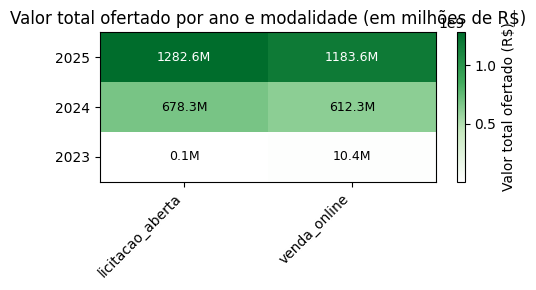

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

matriz = (
    df
      .pivot_table(
          index="ano",
          columns="modalidade_de_venda.x",
          values="valor_oferta",
          aggfunc="sum",
          fill_value=0
      )
)

# ordenar linhas (maior em cima)
matriz = matriz.loc[matriz.sum(axis=1).sort_values(ascending=False).index, :]

cmap = LinearSegmentedColormap.from_list(
    "white_to_green",
    ["#ffffff", "#c7e9c0", "#41ab5d", "#006d2c"]
)

plt.figure(figsize=(5, 3))
img = plt.imshow(matriz.values, cmap=cmap, aspect="auto")
plt.colorbar(img, label="Valor total ofertado (R$)")

plt.xticks(np.arange(len(matriz.columns)), matriz.columns, rotation=45, ha="right")
plt.yticks(np.arange(len(matriz.index)), matriz.index)

# valores nas células (formatado em milhões, 1 casa)
for i in range(matriz.shape[0]):
    for j in range(matriz.shape[1]):
        v = matriz.values[i, j]
        txt = f"{v/1_000_000:.1f}M" if v != 0 else "0"
        plt.text(j, i, txt, ha="center", va="center", fontsize=9,
                 color="black" if v < matriz.values.max() * 0.6 else "white")

plt.title("Valor total ofertado por ano e modalidade (em milhões de R$)")
plt.tight_layout()
plt.show()


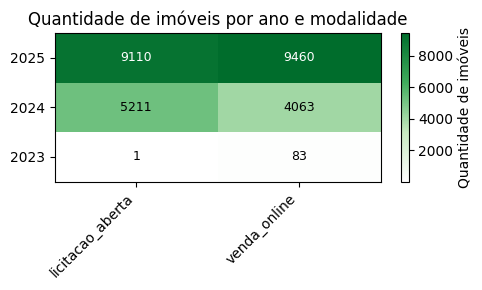

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# matriz tipo x modalidade
matriz = (
    summary_ano
      .pivot_table(
          index="ano",
          columns="modalidade_de_venda.x",
          values="qtd_imoveis",
          aggfunc="sum",
          fill_value=0
      )
)

matriz = matriz.loc[matriz.sum(axis=1).sort_values(ascending=False).index, :]

# paleta: branco → verde escuro
cmap = LinearSegmentedColormap.from_list(
    "white_to_green",
    ["#ffffff", "#c7e9c0", "#41ab5d", "#006d2c"]
)

plt.figure(figsize=(5, 3))  # aumenta eixo X
img = plt.imshow(matriz.values, cmap=cmap, aspect="auto")

plt.colorbar(img, label="Quantidade de imóveis")

# eixos
plt.xticks(
    np.arange(len(matriz.columns)),
    matriz.columns,
    rotation=45,
    ha="right"
)
plt.yticks(
    np.arange(len(matriz.index)),
    matriz.index
)

# valores dentro das células
for i in range(matriz.shape[0]):
    for j in range(matriz.shape[1]):
        valor = matriz.values[i, j]
        plt.text(
            j, i, int(valor),
            ha="center", va="center",
            color="black" if valor < matriz.values.max() * 0.6 else "white",
            fontsize=9
        )

plt.title("Quantidade de imóveis por ano e modalidade")
plt.tight_layout()
plt.show()


### Construção dos cenários de modelagem

Em vez de estimar um único modelo, optou-se por construir diferentes cenários de modelagem, variando o conjunto de variáveis explicativas. Essa estratégia permite avaliar como a inclusão de informações locacionais, financeiras e institucionais afeta o desempenho dos modelos.

Os cenários são organizados em dois grandes grupos:
- **Estruturais**, que excluem variáveis diretamente relacionadas a preços e têm foco interpretativo;
- **Preditivos**, que incorporam todas as informações disponíveis com o objetivo de maximizar a acurácia.

In [32]:
# 2.2 Cenários de modelagem (somente mudando FEATURES e cat_cols)

BASE_CAT = ["modalidade_de_venda.x", "tipo"]
ESTADO = ["uf.x"]
CIDADE = ["uf_cidade"]
BAIRRO = ["uf_cidade_bairro_f"]

TIME = ["ano", "mes"]

BASE_NUM = [
    
    "area_total", "area_total_missing",
    "area_privativa", "area_privativa_missing",
    "area_terreno", "area_terreno_missing",

    "quartos", "quartos_missing",
    "salas", "salas_missing",
    "vagas_garagem", "vagas_garagem_missing",
    "lavabos", "lavabos_missing",
    "suites", "suites_missing",

    "cozinhas", "cozinhas_missing",
    "varandas", "varandas_missing",
    "sacadas", "sacadas_missing",
    "terracos", "terracos_missing",
    "areas_servico", "areas_servico_missing",
    "dce", "dce_missing",
    "churrasqueiras", "churrasqueiras_missing",
    "wc", "wc_missing",
    "wc_emp", "wc_emp_missing",
]

PRICE = ["preco"]
VALUATION = ["valor_de_avaliacao"]

SCENARIOS = {
    # modelo estrutural (sem âncoras monetárias)
    "structural_uf": {
        "modelselected": "CatBoostRegressor",
        "features": BASE_NUM + BASE_CAT + ESTADO + TIME,
        "cat_cols": BASE_CAT + ESTADO
    },
    "structural_uf_city": {
        "modelselected": "CatBoostRegressor",
        "features": BASE_NUM + BASE_CAT + TIME + ESTADO + CIDADE,
        "cat_cols": BASE_CAT + ESTADO + CIDADE
    },
    "structural_uf_city_bairro": {
        "modelselected": "CatBoostRegressor",
        "features": BASE_NUM + BASE_CAT + TIME + ESTADO + CIDADE + BAIRRO,
        "cat_cols": BASE_CAT + ESTADO + CIDADE + BAIRRO
    },
    "structural_city": {
        "modelselected": "CatBoostRegressor",
        "features": BASE_NUM + BASE_CAT + TIME + CIDADE,
        "cat_cols": BASE_CAT + CIDADE
    },
    "structural_bairro": {
        "modelselected": "CatBoostRegressor",
        "features": BASE_NUM + BASE_CAT + TIME + BAIRRO,
        "cat_cols": BASE_CAT + BAIRRO
    },
    "valor_avaliacao_uf": {
        "modelselected": "CatBoostRegressor",
        "features": VALUATION + BASE_NUM + BASE_CAT + TIME + ESTADO,
        "cat_cols": BASE_CAT + ESTADO
    },
    "valor_avaliacao_uf_city": {
        "modelselected": "CatBoostRegressor",
        "features": VALUATION + BASE_NUM + BASE_CAT + TIME + ESTADO + CIDADE,
        "cat_cols": BASE_CAT + ESTADO + CIDADE
    },
    "valor_avaliacao_uf_city_bairro": {
        "modelselected": "CatBoostRegressor",
        "features": VALUATION + BASE_NUM + BASE_CAT + TIME + ESTADO + CIDADE + BAIRRO,
        "cat_cols": BASE_CAT + ESTADO + CIDADE + BAIRRO
    },
    "valor_avaliacao_city": {
        "modelselected": "CatBoostRegressor",
        "features": VALUATION + BASE_NUM + BASE_CAT + TIME + CIDADE,
        "cat_cols": BASE_CAT + CIDADE
    },
    "valor_avaliacao_bairro": {
        "modelselected": "CatBoostRegressor",
        "features": VALUATION + BASE_NUM + BASE_CAT + TIME + BAIRRO,
        "cat_cols": BASE_CAT + BAIRRO
    },
    # upper bound preditivo (com âncoras monetárias)
    "predictive_uf": {
        "modelselected": "CatBoostRegressor",
        "features": PRICE + VALUATION + BASE_NUM + BASE_CAT + TIME + ESTADO,
        "cat_cols": BASE_CAT + ESTADO
    },
    "predictive_uf_city_city": {
        "modelselected": "CatBoostRegressor",
        "features": PRICE + VALUATION + BASE_NUM + BASE_CAT + TIME + ESTADO + CIDADE,
        "cat_cols": BASE_CAT + ESTADO + CIDADE
    },
    "predictive_uf_city_bairro": {
        "modelselected": "CatBoostRegressor",
        "features": PRICE + VALUATION + BASE_NUM + BASE_CAT + TIME + ESTADO + CIDADE + BAIRRO,
        "cat_cols": BASE_CAT + ESTADO + CIDADE + BAIRRO
    },
    "predictive_city": {
        "modelselected": "CatBoostRegressor",
        "features": PRICE + VALUATION + BASE_NUM + BASE_CAT + TIME + CIDADE,
        "cat_cols": BASE_CAT + CIDADE
    },
    "predictive_bairro": {
        "modelselected": "CatBoostRegressor",
        "features": PRICE + VALUATION + BASE_NUM + BASE_CAT + TIME + BAIRRO,
        "cat_cols": BASE_CAT + BAIRRO                                                       
    },
}

ACTIVE_SCENARIO = "structural_uf"  # <-- troque aqui quando quiser

FEATURES = SCENARIOS[ACTIVE_SCENARIO]["features"]
cat_cols = SCENARIOS[ACTIVE_SCENARIO]["cat_cols"]
modelselected = SCENARIOS[ACTIVE_SCENARIO]["modelselected"]

X = df[FEATURES].copy()
X.shape

(27928, 39)

### Modelo baseline: regressão linear

Como referência inicial, estima-se um modelo baseline de regressão linear. Esse modelo tem caráter puramente comparativo e não busca capturar relações complexas ou não lineares.

Variáveis locacionais em níveis muito desagregados, como município e bairro, não possuem interpretação métrica e sua inclusão exigiria a criação de um grande número de dummies, resultando em um modelo pouco parcimonioso. Por esse motivo, o baseline linear utiliza uma representação espacial mais agregada.


In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def run_linear_baseline(df, features, cat_cols):
    X = df[features].copy()
    y = np.log(df["valor_oferta"])

       
    X_train, X_test = X[~is_test], X[is_test]
    y_train, y_test = y[~is_test], y[is_test]

    from sklearn.impute import SimpleImputer

    num_cols = [c for c in features if c not in cat_cols]

    preprocessor = ColumnTransformer(
        transformers=[
            # categóricas: imputar missing -> depois one-hot
            ("cat", Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
            ]), cat_cols),

            # numéricas: imputar missing -> depois passa
            ("num", Pipeline(steps=[
                ("imputer", SimpleImputer(strategy="median"))
            ]), num_cols),
        ],
        remainder="drop"
    )

    model = Pipeline([
        ("prep", preprocessor),
        ("lr", LinearRegression())
    ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae  = float(mean_absolute_error(y_test, y_pred))
    r2   = float(r2_score(y_test, y_pred))

    return rmse, mae, r2

In [34]:
linear_feats = BASE_CAT + BASE_NUM
linear_cats  = BASE_CAT

rmse, mae, r2 = run_linear_baseline(df, linear_feats, linear_cats)

baseline_row = {
    "model": "LinearRegression", 
    "scenario": "basic_linear",
    "rmse_log": rmse,
    "mae_log": mae,
    "r2": r2,
    "best_iteration": "n/a"
}

pd.DataFrame([baseline_row])

,model,scenario,rmse_log,mae_log,r2,best_iteration
0,LinearRegression,basic_linear,0.574617,0.414028,0.236296,n/a


### Modelos baseados em árvores (CatBoost)

Para lidar com não linearidades, interações complexas e variáveis categóricas de alta cardinalidade, utilizam-se modelos baseados em árvores, em particular o CatBoost. Essa classe de modelos permite incorporar variáveis locacionais e institucionais de forma flexível, sem a necessidade de codificação manual por dummies.

O código a seguir implementa um loop que estima automaticamente todos os cenários definidos anteriormente, utilizando o mesmo procedimento de treino, validação e avaliação.

In [35]:
from catboost import CatBoostRegressor

def run_scenario(df, scenario_name, seed=42):
    feats = SCENARIOS[scenario_name]["features"]
    cats  = SCENARIOS[scenario_name]["cat_cols"]

    X = df[feats].copy()
    y = np.log(df["valor_oferta"])

    X_train_full = X.loc[~is_test].copy()
    X_test       = X.loc[is_test].copy()
    y_train_full = y.loc[~is_test].copy()
    y_test       = y.loc[is_test].copy()

    # =========================
    # 2) Validação interna (últimos 20% do TREINO)
    # =========================
    cutoff_val = df.loc[~is_test, "data_licitacao_dt"].quantile(0.8)
    is_val = df.loc[~is_test, "data_licitacao_dt"] >= cutoff_val

    X_train = X_train_full.loc[~is_val].copy()
    X_val   = X_train_full.loc[is_val].copy()
    y_train = y_train_full.loc[~is_val].copy()
    y_val   = y_train_full.loc[is_val].copy()

    # =========================
    # 3) Garantir categóricas como string
    # =========================
    for c in cats:
        X_train[c] = X_train[c].astype(str)
        X_val[c]   = X_val[c].astype(str)
        X_test[c]  = X_test[c].astype(str)

    cat_idx = [X_train.columns.get_loc(c) for c in cats]

    # =========================
    # 4) Modelo
    # =========================
    model = CatBoostRegressor(
        loss_function="RMSE",
        iterations=2000,
        learning_rate=0.05,
        depth=8,
        random_seed=seed,
        verbose=False
    )

    model.fit(
        X_train, y_train,
        cat_features=cat_idx,
        eval_set=(X_val, y_val),
        use_best_model=True
    )

    best_iter = model.get_best_iteration()

    # =========================
    # 5) Avaliação FINAL (teste intocado)
    # =========================
    y_pred = model.predict(X_test)

    rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae  = float(mean_absolute_error(y_test, y_pred))
    r2   = float(r2_score(y_test, y_pred))

    # =========================
    # 6) Importâncias
    # =========================
    importances = model.get_feature_importance()
    feat_names = X_train.columns

    top = (
        pd.DataFrame({
            "feature": feat_names,
            "importance": importances
        })
        .sort_values("importance", ascending=False)
        .head(3)
        .reset_index(drop=True)
    )

    return rmse, mae, r2, top, best_iter


## Resultados

A tabela a seguir resume o desempenho dos diferentes cenários de modelagem, permitindo comparar diretamente os ganhos obtidos com a introdução de modelos não lineares e diferentes níveis de granularidade espacial.


In [36]:
rows = []

for name in SCENARIOS.keys():
    rmse, mae, r2, top, best_iter = run_scenario(df, name)

    row = {
        "model": "CatBoost",
        "scenario": name,
        "rmse_log": rmse,
        "mae_log": mae,
        "r2": r2,
        "best_iteration": best_iter
    }

    for i in range(len(top)):
        row[f"top{i+1}_f"] = top.loc[i, "feature"]
        row[f"top{i+1}_i"] = top.loc[i, "importance"]

    rows.append(row)

results = pd.DataFrame(rows)

results = pd.concat(
    [pd.DataFrame([baseline_row]), results],
    ignore_index=True
)

results
    

KeyboardInterrupt: 

## Resultados e interpretação

Os resultados evidenciam ganhos substanciais de desempenho ao se substituir o modelo linear baseline por modelos baseados em árvores. Enquanto a regressão linear apresenta baixo poder explicativo, os modelos não lineares capturam de forma mais adequada a relação entre características físicas, locacionais e institucionais dos imóveis e seus preços.

Nos modelos estruturais, observa-se que a localização é o principal determinante do preço, com ganhos relevantes à medida que se aumenta a granularidade espacial. A combinação de níveis hierárquicos (UF e município) melhora o desempenho em relação ao uso isolado de um único nível, ainda que essa informação seja redundante em termos estritos. Esse resultado sugere que variáveis hierárquicas atuam como um mecanismo de regularização no aprendizado dos modelos baseados em árvores.

A inclusão de variáveis financeiras, em especial o valor de avaliação divulgado pela Caixa, produz um salto expressivo de desempenho. Nesse caso, a granularidade espacial torna-se menos relevante, indicando que o modelo passa a capturar principalmente a relação entre valor de avaliação e preco com valor de oferta (valor de arremate). Esses modelos devem ser interpretados como ferramentas preditivas, e não como modelos estruturais de formação de preços.

De forma geral, os resultados reforçam a distinção entre modelos com foco interpretativo e modelos voltados à maximização da acurácia, bem como a importância de alinhar a especificação do modelo ao objetivo da análise.

## Extensões futuras

Como extensão natural deste trabalho, pretende-se incorporar coordenadas geográficas e técnicas de clusterização espacial, como o HDBSCAN, para capturar heterogeneidade intraurbana de forma contínua, reduzindo a dependência de divisões administrativas tradicionais.
